In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Ensure GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    # Set memory growth for each GPU
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU(s) are available for training!")
else:
    print("GPU not found, using CPU instead.")

# Set policy for mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

Num GPUs Available:  1
GPU(s) are available for training!


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


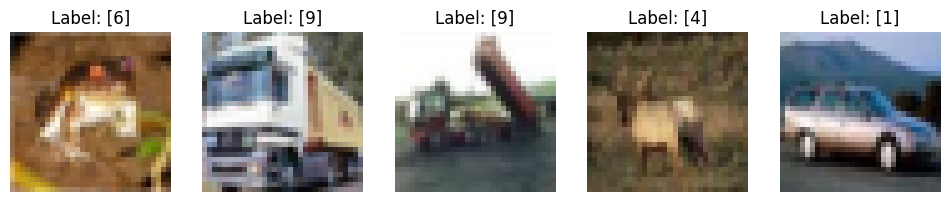

Data loading and preprocessing complete.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load CIFAR-10 dataset
(train_data, train_labels), (test_data, test_labels) = datasets.cifar10.load_data()

# Normalize image data to a range of [0, 1]
train_data, test_data = train_data / 255.0, test_data / 255.0

# Set up data augmentation for the training set
train_augmenter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation transformations to the training dataset
train_data_generator = train_augmenter.flow(train_data, train_labels, batch_size=64)

# Split the training data into a smaller training set and a validation set (80% training, 20% validation)
validation_data = train_data[40000:]  # 20% for validation
validation_labels = train_labels[40000:]
train_data = train_data[:40000]  # Use the first 80% for training
train_labels = train_labels[:40000]

# Normalize the validation data
validation_data = validation_data / 255.0

# Function to show a few example images
def display_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Display sample images from the training set
display_sample_images(train_data, train_labels, num_samples=5)

print("Data loading and preprocessing are now complete.")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers

# Step 1: Patch Extraction Layer
class PatchExtractionLayer(layers.Layer):
    def __init__(self, patch_size, patch_depth):
        super(PatchExtractionLayer, self).__init__()
        self.patch_size = patch_size
        self.patch_depth = patch_depth

    def build(self, input_shape):
        self.input_height, self.input_width = input_shape[1], input_shape[2]
        self.convolution = layers.Conv2D(
            filters=self.patch_depth, 
            kernel_size=self.patch_size, 
            strides=self.patch_size, 
            padding='valid'
        )
        super(PatchExtractionLayer, self).build(input_shape)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        extracted_patches = self.convolution(images)  # (batch_size, patch_grid_height, patch_grid_width, patch_depth)
        extracted_patches = tf.reshape(extracted_patches, (batch_size, -1, self.patch_depth))  # Reshape to (batch_size, num_patches, patch_depth)
        return extracted_patches

    def compute_output_shape(self, input_shape):
        patch_grid_height = self.input_height // self.patch_size
        patch_grid_width = self.input_width // self.patch_size
        num_patches = patch_grid_height * patch_grid_width
        return (input_shape[0], num_patches, self.patch_depth)


# Step 2: Transformer Encoder Block
class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super(EncoderBlock, self).__init__()
        self.attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn_block = models.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout_layer = layers.Dropout(0.1)

    def build(self, input_shape):
        super(EncoderBlock, self).build(input_shape)

    def call(self, inputs, training=False):
        attention_output = self.attention_layer(inputs, inputs)
        attention_output = self.dropout_layer(attention_output, training=training)
        attention_output = self.layernorm1(inputs + attention_output)  # Add & Normalize

        ffn_output = self.ffn_block(attention_output)
        ffn_output = self.dropout_layer(ffn_output, training=training)
        final_output = self.layernorm2(attention_output + ffn_output)  # Add & Normalize

        return final_output


# Step 3: Vision Transformer with CNN Blocks
class VisionTransformerWithCNN(models.Model):
    def __init__(self, embedding_dim, num_encoder_layers, num_attention_heads, mlp_dim, num_classes, patch_size, patch_depth, input_shape):
        super(VisionTransformerWithCNN, self).__init__()

        self.patch_size = patch_size
        self.input_shape = input_shape
        self.num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

        # Step 1: CNN Block for initial feature extraction
        self.feature_extractor = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(256, activation='relu')
        ])

        # Step 2: Patch Extraction Layer
        self.patch_extractor = PatchExtractionLayer(patch_size, patch_depth)

        # Step 3: Positional Encoding (trainable)
        self.positional_encoding = self.add_weight(
            shape=(self.num_patches, embedding_dim),
            initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
            trainable=True,
            name="positional_encoding"
        )

        # Step 4: Embedding Layer
        self.embedding_layer = layers.Dense(embedding_dim)

        # Step 5: Transformer Encoder Blocks
        self.transformer_layers = [EncoderBlock(embedding_dim, num_attention_heads, mlp_dim) for _ in range(num_encoder_layers)]

        # Step 6: Output Classifier
        self.output_classifier = models.Sequential([
            layers.LayerNormalization(),
            layers.GlobalAveragePooling1D(),
            layers.Dense(512, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs, training=False):
        # Step 1: Initial feature extraction via CNN block
        x = self.feature_extractor(inputs)
        
        # Step 2: Extract patches from the image
        patches = self.patch_extractor(inputs)  # (batch_size, num_patches, patch_depth)

        # Step 3: Apply positional encoding and embedding
        x = self.embedding_layer(patches)  # (batch_size, num_patches, embedding_dim)
        x += self.positional_encoding  # Add positional encoding to the embeddings

        # Step 4: Pass through transformer encoder layers
        for layer in self.transformer_layers:
            x = layer(x, training=training)

        # Step 5: Apply final classifier head
        x = self.output_classifier(x)
        return x


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define constants
NUM_CLASSES = 10  # Number of output classes (CIFAR-10 has 10 classes)
PATCH_DIM = 768  # Patch embedding dimension (used in Vision Transformer)
IMAGE_SHAPE = (32, 32, 3)  # Input image dimensions for CIFAR-10
BATCH_SIZE = 32  # Batch size for training

# Set hyperparameters for Vision Transformer model
embedding_dim = 512  # Embedding size for transformer layers
num_transformer_layers = 8  # Number of transformer layers
num_attention_heads = 4  # Attention heads per transformer block
mlp_hidden_dim = 256  # Hidden layer size for MLP after the attention mechanism
patch_size = 16  # Size of each patch for splitting input image
patch_embedding_dim = 512  # Dimension of patch embeddings
input_shape = (32, 32, 3)  # Input shape for CIFAR-10 images

# Create VisionTransformerCNN model with specified hyperparameters
transformer_model = VisionTransformerWithCNN(
    embedding_dim=embedding_dim, 
    num_encoder_layers=num_transformer_layers, 
    num_attention_heads=num_attention_heads, 
    mlp_dim=mlp_hidden_dim, 
    num_classes=NUM_CLASSES, 
    patch_size=patch_size, 
    patch_depth=patch_embedding_dim, 
    input_shape=input_shape
)

# Compile the model using the Adam optimizer with learning rate decay
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4, clipvalue=1.0)
transformer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callback for early stopping to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

# Define learning rate scheduler to reduce the learning rate when the validation loss plateaus
lr_scheduler_callback = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=5e-5
)

# Train the model with the callbacks for early stopping and learning rate adjustment
training_history = transformer_model.fit(
    train_images, 
    train_labels, 
    epochs=25, 
    batch_size=BATCH_SIZE, 
    validation_data=(val_images, val_labels),
    callbacks=[early_stop_callback, lr_scheduler_callback],
    verbose=1  # Display progress bar during training
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = transformer_model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 51ms/step - accuracy: 0.0988 - loss: 2.4157 - val_accuracy: 0.1016 - val_loss: 2.3027 - learning_rate: 5.0000e-04
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.0991 - loss: 2.3030 - val_accuracy: 0.0952 - val_loss: 2.3047 - learning_rate: 5.0000e-04
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.1029 - loss: 2.3028 - val_accuracy: 0.0952 - val_loss: 2.3028 - learning_rate: 5.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.1012 - loss: 2.3028 - val_accuracy: 0.1014 - val_loss: 2.3025 - learning_rate: 5.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.1014 - loss: 2.3032 - val_accuracy: 0.0952 - val_loss: 2.3027 - learning_rate: 5.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.0998 - loss: 2.3026 - val_accuracy: 0.0977 - val_loss: 2.3027 - learning_rate: 5.0000e-04
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on test data and get accuracy and loss
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Make predictions on the test dataset
predictions = model.predict(test_images)

# Convert predictions to class labels (for multi-class classification, use argmax)
predicted_labels = np.argmax(predictions, axis=1)

# Compute precision, recall, and F1-score
precision = precision_score(test_labels, predicted_labels, average='weighted')  # Weighted for multi-class
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(NUM_CLASSES))
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0968 - loss: 2.3030
Test accuracy: 0.10000000149011612, Test loss: 2.302760362625122
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Precision: 0.0100
Recall: 0.1000
F1-score: 0.0182


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


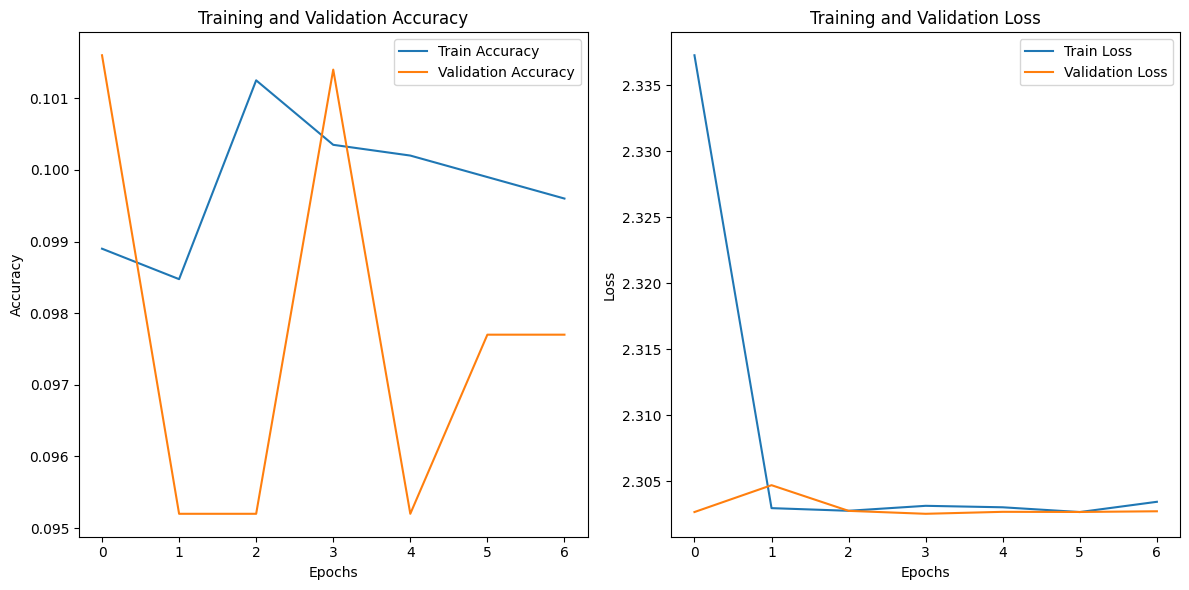

In [17]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

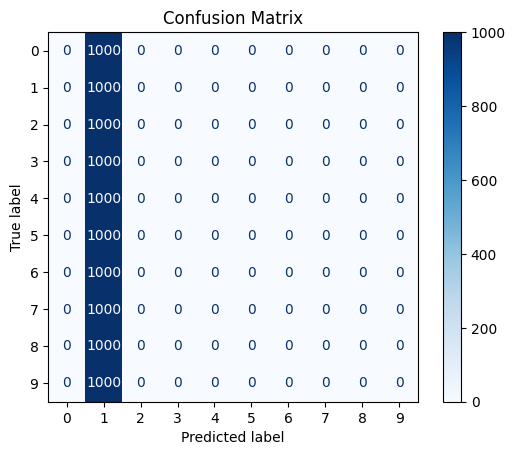

In [18]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(NUM_CLASSES))

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('vision_transformer_model.h5')
model.save('vision_transformer_model.keras')
# model.save('vision_transformer_model.tf')